Text(0, 0.5, 'Neuron')

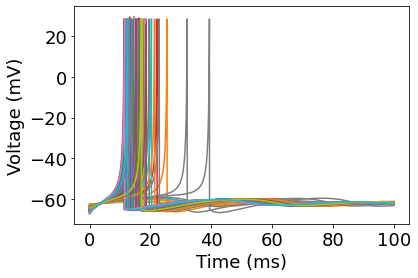

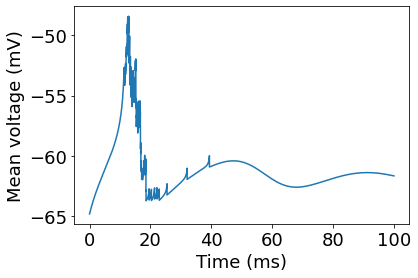

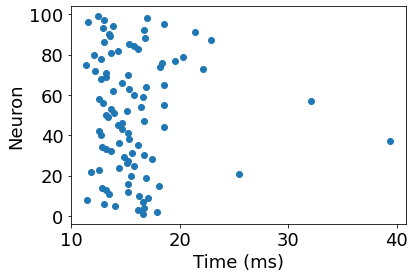

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns

np.random.seed(101)

# Numerical parameters
N = 100               # Number of neurons
T = 100             # Final time in ms
M = 50000           # Max number of spikes
dt = 0.005          
t0 = 0              

# Model parameters
k = 1              
I = 0.15            
a = 0.1             
b = 0.26            
c = -65             
d = -1              
v_reset = c         
v_thresh = 30       


v_init = np.random.normal(-65, 1, size=(N))  
u_init = b*v_init  # Not sure what u_init should be                        


t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))   



def dxdt(t, x, k, a, b, I):
    v = x[:N]   
    u = x[N:2*N]  
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I)   
    dudt = k * a * (b * v - u)  
    
    return np.concatenate([dvdt, dudt])



def v_spike(t, x, k, a, b, I):
    return x[:N].max() - v_thresh   
v_spike.terminal = True
v_spike.direction = 1  



spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0


while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init])  
    
    
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1] 
    
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        
        v_init[spike] = v_reset
        u_init[spike] += d  # Check this is correct
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1




colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)


plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all,y_all[:N,:].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')


spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')